In [1]:
import numpy as np
import theano
import theano.tensor as T
from theano import function
from exoplanet.theano_ops.kepler import KeplerOp
import matplotlib.pyplot as plt
from celmech.disturbing_function import get_fg_coeffs
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def getOmegaMatrix(n):
    """
    Get the 2n x 2n skew-symmetric block matrix:
          [0 , I_n]
          [-I_, 0 ]
    that appears in Hamilton's equations.
    
    Arguments
    ---------
    n : int
        Determines matrix dimension
    
    Returns
    -------
    numpy.array
    """
    return np.vstack(
        (
        np.concatenate([np.zeros((n,n)),np.eye(n)]).T,
        np.concatenate([-np.eye(n),np.zeros((n,n))]).T
    )
    )
    

In [3]:
def calc_DisturbingFunction_with_sinf_cosf(alpha,e1,e2,w1,w2,sinf1,cosf1,sinf2,cosf2):
    """
    Compute the value of the disturbing function 
    .. math::
        \frac{a'}{|r-r'|} - a'\frac{r.r'}{|r'^3|}
    from a set of input orbital elements for coplanar planets.
    
    Arguments
    ---------
    alpha : float
        semi-major axis ratio
    e1 : float
        inner eccentricity
    e2 : float
        outer eccentricity
    w1 : float
        inner long. of peri
    w2 : float
        outer long. of peri
    sinf1 : float
        sine of inner planet true anomaly
    cosf1 : float
        cosine of inner planet true anomaly
    sinf2 : float
        sine of outer planet true anomaly
    cosf2 : float
        cosine of outer planet true anomaly
    
    Returns
    -------
    float :
        Disturbing function value 
    """
    r1 = alpha * (1-e1*e1) /(1 + e1 * cosf1)
    _x1 = r1 * cosf1
    _y1 = r1 * sinf1 
    Cw1 = T.cos(w1)
    Sw1 = T.sin(w1)
    x1 = Cw1 * _x1  - Sw1 * _y1
    y1 = Sw1 * _x1  + Cw1 * _y1

    r2 = (1-e2*e2) /(1 + e2 * cosf2)
    _x2 = r2 * cosf2
    _y2 = r2 * sinf2
    Cw2 = T.cos(w2)
    Sw2 = T.sin(w2)
    x2 = Cw2 * _x2  - Sw2 * _y2
    y2 = Sw2 * _x2  + Cw2 * _y2

    # direct term
    dx = (x2 - x1)
    dy = (y2 - y1)
    dr2 = dx*dx + dy*dy
    direct = 1 / T.sqrt(dr2)

    # indirect term
    r1dotr = (x2 * x1 + y2 * y1)
    r1sq = x2*x2 + y2*y2
    r1_3 = 1 / r1sq / T.sqrt(r1sq)
    indirect = -1 * r1dotr * r1_3

    return direct+indirect

# Numerical calculation of the Hamiltonian and its derivatives

The code below computes the integrable Hamiltonian
 $$    {\cal H}(J,\theta; J^*) = 
    -\frac{1}{2k^2}A(J-J^*)^2 + H'_\text{res}(J,\theta) 
 $$
  
where 
$$
H'_\text{res}(J,\theta) = -2\epsilon  R_{\text{res},W=0}
$$
and $R_{\text{res},W=0}$ is computed via numerical quadrature. 

The equations of motion,
$$
\frac{d}{dt}\{\theta,\theta^*,J,J^*\} = \Omega\cdot \nabla_{\{\theta,\theta^*,J,J^*\}} {\cal H}
$$
and their Jacobian,
$$
\Omega\nabla^2{\cal H}
$$
are also computed using Theano.



In [52]:
##############################
# Set up Theano variables
##############################

# Integers to set resonance as j:j-k
j,k = T.lscalars('jk')

# Planet masses: m1,m2
m1,m2 = T.dscalars(2)

# Constants in Eq. (11)
f,g = T.dscalars(2)

# Planet and star mass variables
Mstar = 1
mu1 = m1 / (Mstar + m1)
mu2 = m2 / (Mstar + m2)
eps = m1 * mu2 / (mu1 + mu2) / Mstar

# Resonant semi-major axis ratio
alpha = ((j-k)/j)**(2/3) * ((Mstar + m1) / (Mstar+m2))**(1/3)

# Constants in Eq. (15)
fTilde = T.sqrt((mu1+mu2) / (mu1 * T.sqrt(alpha))) * f
gTilde = T.sqrt((mu1+mu2) / mu2 ) * g

# Constant in Eq. (8)
A = 1.5 * j * (mu1 + mu2) * (j / mu2 + (j-k) / mu1 / T.sqrt(alpha) )

# Dynamical variables:
dyvars = T.vector()
theta,theta_star,J,J_star = [dyvars[i] for i in range(4)]

# Angle variable to average disturbing function over
kappa = T.dvector()

# Quadrature weights
quad_weights = T.dvector('w')

# Convert dynamical variables to eccentricities and angles:
# Note: 
#   Q isset to zero since it does not 
#   enter disturbing function except in combinations
#   with z and w.
Q = T.as_tensor(0)  
z = Q / k - theta

# See Eq. 20
Zsq = J * (fTilde*fTilde + gTilde*gTilde) / (f*f+g*g)
Z = T.sqrt(Zsq)

# Set W to zero
Wsinw,Wcosw = 0, 0
Zsinz,Zcosz = Z * T.sin(z), Z * T.cos(z)

# Convert Z and W to planet eccentricities
atan_f_g = T.arctan2(g , f)
c,s = T.cos(atan_f_g),T.sin(atan_f_g)

e1cos = c * Zcosz - s * Wcosw
e1sin = c * Zsinz - s * Wsinw

e2cos = s * Zcosz + c * Wcosw
e2sin = s * Zsinz + c * Wsinw

w1 = T.arctan2(e1sin,e1cos)
w2 = T.arctan2(e2sin,e2cos)

e1 = T.sqrt(e1sin*e1sin + e1cos*e1cos)
e2 = T.sqrt(e2sin*e2sin + e2cos*e2cos)

# Planets' mean longitudes
l1 = Q / k - j * kappa
l2 = Q / k + (k-j) * kappa

# Planets mean anomalies
M1 = l1 - w1
M2 = l2 - w2

# Convert mean to true anomalies using 
# function 'exoplanet.theano_ops.kepler.KeplerOp'
ko = KeplerOp()
sinf1,cosf1 =  ko( M1, e1 + T.zeros_like(M1) )
sinf2,cosf2 =  ko( M2, e2 + T.zeros_like(M2) )

# Vector of distrubing function values with same dimension as kappa vector
DFfull = calc_DisturbingFunction_with_sinf_cosf(alpha,e1,e2,w1,w2,sinf1,cosf1,sinf2,cosf2)

# Average distrubing function by weighting values with user-specified 
# quadrature weights.
DFav = DFfull.dot(quad_weights)

# Hamiltonian
Hkep = -0.5 * A/k/k * (J - J_star) * (J - J_star)
Hres = -2 * eps * DFav

# ******************IMPORTANT NOTE*************************
# I have *NOT* subtraced off the secular component of 
# the disturbing function. This means that the Hamiltonian 
# differs slightly from the one defined in the paper. 
# This is generally of little consequence to the resonant
# dynamics but should be borne in mind when exploring
# secular dynamics.
# *********************************************************
H = Hkep + Hres 

# Gradient and hessian of Hamiltonian w.r.t. phase space variables
gradHtot = T.grad(H,wrt=dyvars)
hessHtot = theano.gradient.hessian(H,wrt=dyvars)

# Flow vector and jacobian for equations of motion
OmegaTens = T.as_tensor(getOmegaMatrix(2))
H_flow_vec = OmegaTens.dot(gradHtot)
H_flow_jac = OmegaTens.dot(hessHtot)



In [5]:
#####################################################
# Set parameters for compiling functions with Theano 
#####################################################

# Set Gauss-Legendre quadrature order
QUAD_ORDER = 40 

# Get numerical quadrature nodes and weights
nodes,weights = np.polynomial.legendre.leggauss(QUAD_ORDER)

# Rescale for integration interval from [-1,1] to [-pi,pi]
nodes = nodes * np.pi
weights = weights * 0.5

# Specify the j:j-k
res_j,res_k = 3,1

# Get f and g coefficient with celmech
f_N,g_N = get_fg_coeffs(res_j,res_k)

# Set default planet mass, if desired
DEFAULT_MASS = 6e-6

# 'ins' will set the inputs of Theano functions compiled below
ins = [
        dyvars,
        theano.In(m1,name="m1",value=DEFAULT_MASS),
        theano.In(m2,name="m2",value=DEFAULT_MASS)
      ]

# 'givens' will fix some parameters of Theano functions compiled below
givens=[(j,res_j),
        (k,res_k),
        (f,f_N),
        (g,g_N),
        (kappa,nodes),
        (quad_weights,weights)
       ]

In [6]:
##########################
# Compile Theano functions  
##########################

# Note that this may take a while...
H_fn = theano.function(
    inputs=ins,
    outputs=H,
    givens=givens
)

In [7]:
H_flow_vec_fn = theano.function(
    inputs=ins,
    outputs=H_flow_vec,
    givens=givens
)

H_flow_jac_fn = theano.function(
    inputs=ins,
    outputs=H_flow_jac,
    givens=givens
)

# Hamiltonian contour plot

The following code computes a grid of Hamiltonian values in variables $(\Delta,\theta)$ where
$$\Delta = \frac{j-k}{j}\frac{P_2}{P_1}-1$$
for user-specified value of $J^*$. 

The value of $J^*$ is set by defining $Z_0$ so that
$$
 J^* = \frac{f^2+g^2}{(\tilde{f})^2+(\tilde{g})^2}Z_0^2~.
$$
This definition is motivated by Equation 20.

In [14]:
# Set Z0 
Z0 = 0.15

# Define grid to compute values on
Ngrid = 128
thetas = np.linspace(0*np.pi,2*np.pi,128)
Deltas =  np.linspace(-0.01,0.01,Ngrid)

# A dictionary for computing some useful 
# quantities for converting from dynamical
# variables to more easily interpreted quanties.
eval_dict = {m1:DEFAULT_MASS,
             m2:DEFAULT_MASS,
             j:res_j,
             k:res_k,
             f:f_N,
             g:g_N
            }

# Equation 20:
Zsq_to_J_Eq20 = (f*f + g*g) / (fTilde*fTilde + gTilde*gTilde)
Zsq_to_J_Eq20 = Zsq_to_J_Eq20.eval(eval_dict)

# Equation 21:
dJ_to_Delta_Eq21 = 1.5 * (mu1+mu2) * (j * mu1*T.sqrt(alpha) + (j-k) * mu2) / (2*k*T.sqrt(alpha)*mu1*mu2)
dJ_to_Delta_Eq21 = dJ_to_Delta_Eq21.eval({k:eval_dict[k] for k in [m1,m2,j,k]})

Jstar = Zsq_to_J_Eq20 * Z0**2
Js = Jstar + Deltas / dJ_to_Delta_Eq21

In [15]:
Z0 = 0.1
Z = np.reshape([H_fn([theta,0,J,Jstar]) for J in Js for theta in thetas],(Ngrid,Ngrid))
X,Y = np.meshgrid(thetas,Deltas)

In [18]:
################################################
# Let's identify the fixed points and separatrix
################################################
from scipy.optimize import root_scalar

def stable_root_rn(J,Jstar):
    """
    Convenience function to look for the stable fixed point by finding
        dtheta/dt = 0
    searching in J with theta=\pi.
    Desinged for use with scipy.optimize.root_scalar
    """
    y = np.array([np.pi,0,J,Jstar])
    f = H_flow_vec_fn(y)[0]
    df = H_flow_jac_fn(y)[0,2]
    return f,df
def unstable_root_rn(J,Jstar):
    """
    Convenience function to look for the unstable root by finding
        dtheta/dt = 0
    searching in J with theta=0.
    
    Desinged for use with scipy.optimize.root_scalar
    """
    y = np.array([0,0,J,Jstar])
    f = H_flow_vec_fn(y)[0]
    df = H_flow_jac_fn(y)[0,2]
    return f,df


rt_st = root_scalar(stable_root_rn,x0=Jstar,args=(Jstar),fprime=True)
rt_unst = root_scalar(unstable_root_rn,x0=Jstar,args=(Jstar),fprime=True)


Eunst = H_fn([0,0,rt_unst.root,Jstar])
Est = H_fn([np.pi,0,rt_st.root,Jstar])



Delta_St = dJ_to_Delta_Eq21 * (rt_st.root-Jstar)
Delta_Unst = dJ_to_Delta_Eq21 * (rt_unst.root-Jstar)

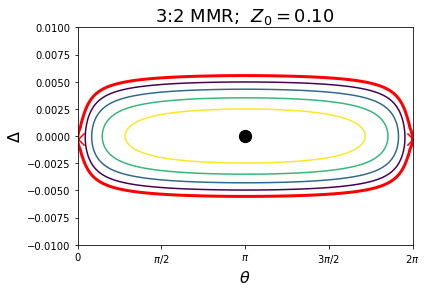

In [28]:
plt.contour(X,Y,Z,np.linspace(Eunst,Est,6)[1:-1])
plt.contour(X,Y,Z,[Eunst],linewidths=[3],colors=['r'],linestyles=['-'])
plt.scatter(np.pi,Delta_St,marker='o',color='k',s=150)
plt.scatter(0,Delta_Unst,marker='x',color='r',s=150)
plt.scatter(2*np.pi,Delta_Unst,marker='x',color='r',s=150)
plt.xlabel(r"$\theta$",fontsize=16)
plt.ylabel(r"$\Delta$",fontsize=16)
plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi])
ax = plt.gca()
ax.xaxis.set_ticklabels(["0",r"$\pi/2$",r"$\pi$",r"$3\pi/2$",r"$2\pi$"]);
plt.title("{}:{} MMR;  $Z_0={:.2f}$".format(res_j,res_j-res_k,Z0),fontsize = 18)

# Semi-analytic determination of secular frequencies

In [29]:
from scipy.integrate import solve_ivp

In [30]:
"""
For calls to solve_ivp variable order should be:
    y[0] = theta
    y[1] = theta*
    y[2] = J
    y[3] = J*
"""


def ydot(t,y):
    """
    dy/dt for scipy.integrate.solve_ivp
    """
    return H_flow_vec_fn(y)

def ydot_jac(t,y):
    """
    grad[dy/dt] for scipy.integrate.solve_ivp
    """
    return H_flow_jac_fn(y)

def event(t,y,J0):
    """
    Determine when J returns to initial
    value, J0
    """
    J = y[2]
    return J - J0


In [31]:
def calc_frequencies(delta_theta,Jstar):
    """
    Determine the dynamical frequencies associated with 
    initial libration amplitude delta_thetaand conserved 
    quantity Jstar.
    
    Based on Henrard (1990, doi: 10.1007/BF00048581).
    
    The equations of motion are integrated until the trajectory
    returns to it's initial value of J  (with the additional
    condtion that dJ/dt has the same sign as it does initially).
    The time it takes for J to return to its initial value is
    the simply libration period. 
    
    The secular frequency is determined as follows:
    the angle $\theta^*$ is related to the canonical 
    action-angle variables $({\cal J},\zeta,I^*,\phi^*)$ by: 
    
    $$
        \theta^* = \phi^* + \rho(\zeta; I^*,{\cal J})
    $$
    
    where $\rho$ is a 2pi periodic function of $\zeta$.
    Therefore, after one libration period,
    $$
     \theta^* = \phi^*(0) + \frac{\Omega_{sec}}\times T
    $$
    where T is the libration period. The secular frequency
    can then be determined from the change in \theta^* over
    one libration period.
    
    Arguments
    ---------
    delta_theta : float
        Intial libration amplitude.
        
    Returns
    -------
    Omega_res : float
        Frequency of (J,theta) degree of freedom.
        
    Omega_sec : float
        Frequency of (J*,theta*) degree of freedom.
        This is the mean precession rate of theta*.
        Note that this Omega_sec differs from the one
        defined in the paper by eps*b_s
        
    Notes
    -----
    Trajectories are initialized with
        y0 = [np.pi + delta_theta,0,J_eq,Jstar]
    Strictly speaking, 
       $$ J  \ne J_eq $$ 
    when $\theta$ is at it's maximum libration value
    so the *true* libration amplitude may differ 
    slightly from the user-specified value 'delta_theta'.
    However, this difference is generally negligible.
    """
    # Symmetric in libration amplitude
    delta_theta = np.abs(delta_theta)
    assert delta_theta <= np.pi, "Not a valid libration amplitude!"
    
    # J0 set to stable equilibrium value
    # (Note: 
    rt = root_scalar(stable_root_rn,x0=Jstar,args=(Jstar),fprime=True)
    J0 = rt.root
    
    # Inital conditions
    y0 = [np.pi + delta_theta,0,J0,Jstar]
    
    # At fixed point, get freq. of linearized system
    if np.isclose(delta_theta,0):
        fvec = H_flow_vec_fn(y0)
        jac = H_flow_jac_fn(y0)
        Omega_res = np.max(np.imag(np.linalg.eigvals(jac)))
        Omega_sec = fvec[1]
        
    # For libration ampltiude of pi, take 
    # secular frequency at usntable fixed point
    # and set Omega_res = 0
    elif np.isclose(delta_theta,np.pi):
        Omega_res = 0
        rt = root_scalar(unstable_root_rn,x0=Jstar,args=(Jstar),fprime=True)
        Junst = rt.root
        Omega_sec = H_flow_vec_fn([0,0,Junst,Jstar])[1]
    # ... otherwise do integration
    else:
        # Stop when J returns to J0 with the proper dJ/dt direction
        eventfn = lambda t,y: event(t,y,J0-1e-14)
        eventfn.terminal=True
        eventfn.direction = +1
        sol = solve_ivp(ydot,
                        t_span=(0,np.inf),
                        y0=y0,
                        jac=ydot_jac,
                        method='Radau',
                        events=[eventfn]                       
                       )

        # Resonant libration period/freq. 
        T = sol.t_events[0][0]
        Omega_res = 2 * np.pi / T 

        # Get state at t=T. 
        # Annoyingly, this is not actually
        # returned by the previous call to solve_ivp.
        sol2 = solve_ivp(ydot,
                        t_span=(sol.t[-1],T),
                        y0=sol.y[:,-1],
                        jac=ydot_jac,
                        method='Radau'
                        )
        theta_star_final = sol2.y[1][-1]
        Omega_sec = theta_star_final / T

    return Omega_res,Omega_sec

In [32]:
# Secular Hamiltonian coefficients evaluated at alpha=a1/a2
from celmech.disturbing_function import laplace_B

def get_secular_f2_and_f10(alpha):
    """
    Calculate f_{2} and f_{10}, the combinations
    Laplace coefficients that appear in the secular
    disturbing function at second order in eccentricity:
    ..math::
        R_\text{sec} = f_2\left(e_1^2 + e_2^2\right) +
                        f_{10} e_1 e_2\cos(\varpi_2-\varpi_1)
    
    Arguments
    ---------
    alpha : float
        The semi-major axis ratio.
    
    Returns
    -------
    f2 : float
    f10 : float
    """
    b01 = laplace_B.eval(1/2,0,1,alpha)
    b02 = laplace_B.eval(1/2,0,2,alpha)
    
    b10 = laplace_B.eval(1/2,1,0,alpha)
    b11 = laplace_B.eval(1/2,1,1,alpha)
    b12 = laplace_B.eval(1/2,1,2,alpha)
    
    
    
    f2 = 0.25 * alpha * b01 + 0.125 * alpha * alpha * b02
    f10 = 0.5 * b10 - 0.5 * alpha * b11 - 0.25 * alpha * alpha * b12
    
    return f2,f10



In [33]:
# Calculate matrices appearing in B7-B9
ang = T.arctan2(gTilde,fTilde)
c,s = T.cos(ang),T.sin(ang)
M2 = T.stacklists([[c,-s],[s,c]])
M1 = T.stacklists([
    [T.sqrt((mu1+mu2)/(mu1*T.sqrt(alpha))), 0 ],
    [0,T.sqrt((mu1+mu2)  / mu2)]
])
M = M1.dot(M2)

M = M.eval(eval_dict)

f2,f10 = get_secular_f2_and_f10(
    ((res_j-res_k)/res_j)**(2/3)
)
Smtrx = np.array([[f2,f10/2],[f10/2,f2]])

# Coefficients a_s,b_s, and c_s defined in Eq. B11
Q = 2 * np.transpose(M).dot( Smtrx.dot(M) )
a_s = Q[0,0]
b_s = Q[1,1]
c_s = Q[0,1] + Q[1,0]

eps_bs = eps.eval({m1:DEFAULT_MASS,m2:DEFAULT_MASS}) * b_s

In [34]:
import glob
from pickle import load
squareArr = lambda x: x.reshape(60,60)
filelist= glob.glob("../new_fmft_grids/fmft_results_j%d_k%d_W_6_newmass.pkl"%(3,1))
finame=filelist[0]
with open(finame,"rb") as f:
    results = load(f)
freqs,amps,Imean,Y = np.array([x[1] for x in results]).T
angle,_zfrac = np.array([x[0] for x in results]).T
sqFreqs = squareArr(freqs)
sqAmps = squareArr(amps)
sqAngle = squareArr(angle)
sqzfrac = squareArr(_zfrac)



In [35]:
Zcross = 0.18838859120485124 

In [50]:
Npt = 25
amps = np.linspace(0.1,np.pi-0.1,30)
libration_amps = np.linspace(0,np.pi,Npt+1)[:-1]
Omega_res,Omega_sec = np.zeros((2,3,Npt))
for ii,Zstar in enumerate([0.25*Zcross,0.5*Zcross,0.75*Zcross]):
    for i,amp in enumerate(libration_amps):
        Jstar = Zsq_to_J_Eq20 * Zstar * Zstar
        Omega_res[ii,i],Omega_sec[ii,i]=calc_frequencies(amp,Jstar)

(0, 20)

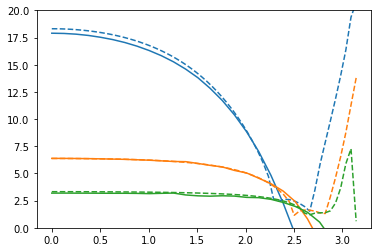

In [51]:
for ii,Zstar in enumerate([0.25*Zcross,0.5*Zcross,0.75*Zcross]):
    i = (np.abs(sqzfrac[:,0]-Zstar/Zcross)).argmin()
    yN = 1e4*sqFreqs[i]
    yA = 2*np.pi*1e4*(Omega_sec[ii]+eps_bs)
    # yA = yA +(yN[0]-yA[0])
    l, = plt.plot(sqAngle[i],yN,'--')
    plt.plot(libration_amps,yA,color=l.get_color())
plt.ylim(0,20)

In [39]:
to_ecc_elements = theano.function(
    inputs=ins,
    outputs = [e1,e2,w1,w2],
    givens=givens,
    on_unused_input='ignore'
)

In [40]:
import rebound as rb

In [42]:
Jstar = 0.0009993164619885892
Jeq = root_scalar(stable_root_rn,args=(Jstar),fprime=True,x0=Jstar).root
yeq = [np.pi,0,Jeq,Jstar]
y0 = np.array(yeq) + np.array([1,0,0,0])

In [62]:
e1N,e2N,w1N,w2N = to_ecc_elements(y0)
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=DEFAULT_MASS,e=e1N,pomega=w1N,l=0,P=(res_j-res_k)/res_j )
sim.add(m=DEFAULT_MASS,e=e2N,pomega=w2N,l=0,P=1)

Qrb,w1rb,w2rb= np.zeros((3,256))
e1rb,e2rb = np.zeros((2,256))
alpha_rb = np.zeros(256)
times=np.linspace(0,1e3,256)
ps = sim.particles
for i,t in enumerate(times):
    sim.integrate(t)
    Qrb[i] = res_j * ps[2].l - (res_j-res_k) * ps[1].l
    w1rb[i]=ps[1].pomega
    w2rb[i]=ps[2].pomega
    e1rb[i]=ps[1].e
    e2rb[i]=ps[2].e
    alpha_rb[i] = ps[1].a / ps[2].a
zrb = np.angle( f_N * e1rb * np.exp(1j * w1rb) + g_N * e2rb * np.exp(1j * w2rb) )

In [63]:
fT,gT = T.stack(fTilde,gTilde).eval({m1:DEFAULT_MASS,m2:DEFAULT_MASS,f:f_N,g:g_N,j:res_j,k:res_k})

In [64]:
Gamma1 = ps[1].m * ((res_j-res_k)/res_j)**(1/3) * e1rb**2
Gamma2 = ps[2].m * e2rb**2

phi = np.angle(fT * np.sqrt(Gamma1) * np.exp(-1j * w1rb) + gT * np.sqrt(Gamma2) * np.exp(-1j * w2rb))
psi = np.angle(-1*gT * np.sqrt(Gamma1) * np.exp(-1j * w1rb) + fT * np.sqrt(Gamma2) * np.exp(-1j * w2rb))

In [65]:
sol = solve_ivp(
    ydot,
    y0=y0,
    t_span=(times[0]*(2*np.pi),times[-1]*(2*np.pi)),
    method='Radau',
    jac=ydot_jac,
    t_eval=times * (2*np.pi)
 )

(0, 6.283185307179586)

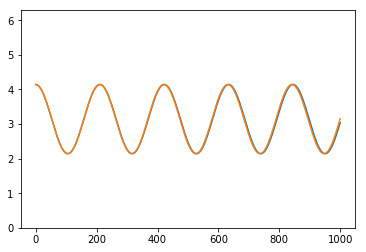

In [66]:
plt.plot(times,np.mod(Qrb - zrb  ,2*np.pi))
plt.plot(sol.t/(2*np.pi),sol.y[0])
plt.ylim(0,2*np.pi)

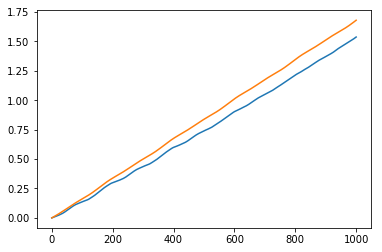

In [70]:
semianalytic_soln = sol.y[0]+sol.y[1] + eps_bs * sol.t
nbody_soln = (phi-psi)
plt.plot(times,nbody_soln-nbody_soln[0])
plt.plot(sol.t/(2*np.pi),semianalytic_soln-semianalytic_soln[0])